In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve, f1_score, matthews_corrcoef, precision_score, recall_score
from sklearn.metrics import make_scorer, cohen_kappa_score
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

In [3]:
# Load the dataset
data = pd.read_csv('df1.csv')
data.head()

,age,parity,gravida,numbabies,gestation,year,Hxob,Hxantenatal,Deliverymethod,Hemamount,Fetalheart,Weight,Educlevel,Status
0,12,0,2,1,41,3,3,5,1,3,1,3.0,1,1
1,13,0,1,1,40,3,3,5,0,1,1,2.9,2,1
2,14,0,2,1,37,2,3,5,1,1,1,2.7,2,1
3,14,0,1,1,38,3,3,5,1,2,1,2.8,1,1
4,14,0,1,1,36,3,3,5,0,2,1,2.8,2,1


In [4]:
data.isna().sum()

age                0
parity             0
gravida            0
numbabies          0
gestation          0
year               0
Hxob               0
Hxantenatal        0
Deliverymethod     0
Hemamount          0
Fetalheart         0
Weight            66
Educlevel          0
Status             0
dtype: int64

In [5]:
# Drop rows with NA values in the 'Weight' column
data.dropna(subset=['Weight'], inplace=True)
data.shape

(6466, 14)

In [6]:
data.isna().sum()

age               0
parity            0
gravida           0
numbabies         0
gestation         0
year              0
Hxob              0
Hxantenatal       0
Deliverymethod    0
Hemamount         0
Fetalheart        0
Weight            0
Educlevel         0
Status            0
dtype: int64

In [7]:
# Separate the features (X) and the target variable (y)
X = data[['age', 'parity', 'gravida', 'numbabies', 'gestation', 'Hemamount', 'Weight', 'Hxob', 'Hxantenatal', 'Deliverymethod', 'Fetalheart', 'year', 'Educlevel']]
y = data['Status']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
# Apply SMOTE oversampling to the training set only
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
# Print oversampled data statistics
print("Original Class Distribution:")
print(y_train.value_counts())

print("\nOversampled Class Distribution:")
print(y_train_resampled.value_counts())

Original Class Distribution:
1    4852
0     320
Name: Status, dtype: int64

Oversampled Class Distribution:
1    4852
0    4852
Name: Status, dtype: int64


In [9]:
# Create a column transformer for one-hot encoding of specific columns
categorical_cols = ['Hxob', 'Hxantenatal', 'Deliverymethod', 'Fetalheart', 'Educlevel']
ct = ColumnTransformer([('encoder', OneHotEncoder(), categorical_cols)], remainder='passthrough')

# Fit and transform the X_train_resampled features using the column transformer
X_train_encoded = ct.fit_transform(X_train_resampled)

# Transform X_test using the fitted column transformer
X_test_encoded = ct.transform(X_test)

In [10]:
# Perform GridSearchCV with Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score

rf_classifier = RandomForestClassifier(random_state=42)

# Define the parameter grid for Random Forest
param_grid = {
    'n_estimators': [50, 100, 200, 300],            # Number of trees in the forest
    'max_depth': [3, 4, 5, 10],                    # Maximum depth of each tree
    'min_samples_split': [3,5,10]
}

# Define the accuracy scorer
accuracy_scorer = make_scorer(accuracy_score)

# Create the GridSearchCV object
grid_search = GridSearchCV(rf_classifier, param_grid, cv=5, scoring=accuracy_scorer)

# Fit the model with GridSearchCV using the oversampled training data
grid_search.fit(X_train_encoded, y_train_resampled)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [3, 4, 5, 10],
                         'min_samples_split': [3, 5, 10],
                         'n_estimators': [50, 100, 200, 300]},
             scoring=make_scorer(accuracy_score))

In [11]:
# Print the optimal parameter values
print("Optimal Parameters:", grid_search.best_params_)

Optimal Parameters: {'max_depth': 10, 'min_samples_split': 3, 'n_estimators': 300}


In [12]:
# Get the best model from GridSearchCV
best_rf_model = grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_rf_model.predict(X_test_encoded)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate the accuracy score
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy Score:", accuracy)

# Calculate precision
precision = precision_score(y_test, y_pred)
print("Precision:", precision)

# Calculate recall
recall = recall_score(y_test, y_pred)
print("Recall:", recall)

# Calculate F1 score
f1 = f1_score(y_test, y_pred)
print("F1 Score:", f1)

# Calculate Cohen's Kappa
kappa = cohen_kappa_score(y_test, y_pred)
print("Cohen's Kappa:", kappa)

# Calculate Matthews Correlation Coefficient (MCC)
mcc = matthews_corrcoef(y_test, y_pred)
print("Matthews Correlation Coefficient (MCC):", mcc)

# Calculate the ROC AUC score
y_prob = best_rf_model.predict_proba(X_test_encoded)[:, 1]
roc_auc = roc_auc_score(y_test, y_prob)
print("ROC AUC:", roc_auc)

Confusion Matrix:
[[  53   21]
 [   5 1215]]
Accuracy Score: 0.9799072642967542
Precision: 0.9830097087378641
Recall: 0.9959016393442623
F1 Score: 0.9894136807817591
Cohen's Kappa: 0.7926077522438111
Matthews Correlation Coefficient (MCC): 0.7991428504808139
ROC AUC: 0.9035445281346922


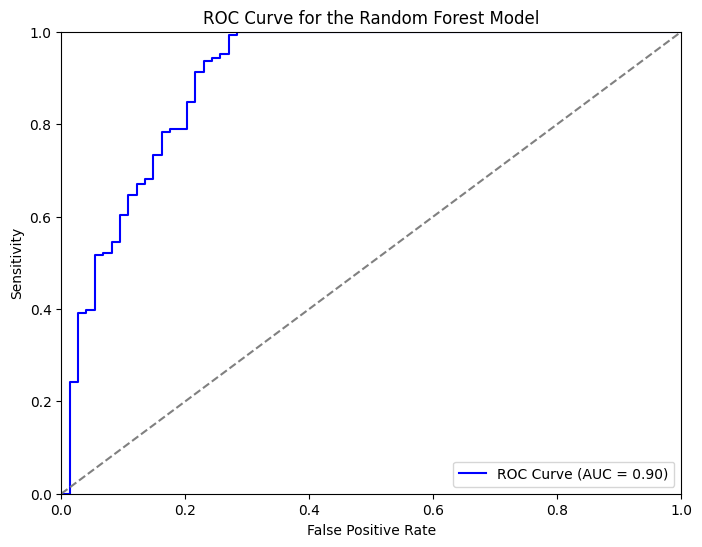

In [13]:
# Plot the ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='b', label='ROC Curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('Sensitivity')
plt.title('ROC Curve for the Random Forest Model')
plt.legend(loc='lower right')
plt.show()